Epoch [1/100], Train Loss: 0.2931
Epoch [2/100], Train Loss: 0.1664
Epoch [3/100], Train Loss: 0.0725
Epoch [4/100], Train Loss: 0.0541
Epoch [5/100], Train Loss: 0.0376
Epoch [6/100], Train Loss: 0.0167
Epoch [7/100], Train Loss: 0.0120
Epoch [8/100], Train Loss: 0.0113
Epoch [9/100], Train Loss: 0.0106
Epoch [10/100], Train Loss: 0.0108
Epoch [11/100], Train Loss: 0.0109
Epoch [12/100], Train Loss: 0.0107
Epoch [13/100], Train Loss: 0.0100
Epoch [14/100], Train Loss: 0.0102
Epoch [15/100], Train Loss: 0.0098
Epoch [16/100], Train Loss: 0.0105
Epoch [17/100], Train Loss: 0.0101
Epoch [18/100], Train Loss: 0.0098
Epoch [19/100], Train Loss: 0.0102
Epoch [20/100], Train Loss: 0.0102
Epoch [21/100], Train Loss: 0.0102
Epoch [22/100], Train Loss: 0.0099
Epoch [23/100], Train Loss: 0.0101
Epoch [24/100], Train Loss: 0.0101
Epoch [25/100], Train Loss: 0.0097
Epoch [26/100], Train Loss: 0.0109
Epoch [27/100], Train Loss: 0.0100
Epoch [28/100], Train Loss: 0.0106
Epoch [29/100], Train Loss: 0

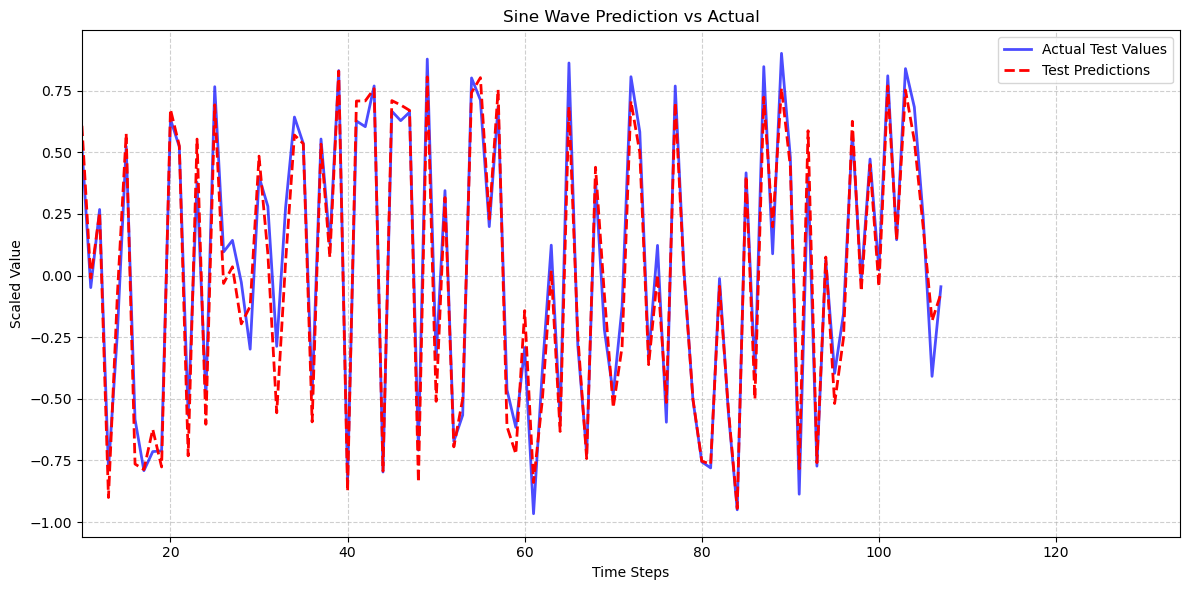

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
np.random.seed(42)

time_steps = np.linspace(0, 50, 500)
data = np.sin(time_steps) + np.random.normal(0, 0.1, len(time_steps))
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data.reshape(-1, 1))

def create_sequence_data(data, seq_length=10):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.float)

X, y = create_sequence_data(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 32, batch_first=True)
        self.linear = nn.Linear(32, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.linear(out)

model = LSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X, y in train_dataloader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

model.eval()
with torch.no_grad():
    y_pred = []
    for X, y in test_dataloader:
        y_pred.extend(model(X).numpy())
y_pred = np.array(y_pred).reshape(-1)

test_indices = np.arange(len(y_test)) + 10  

plt.figure(figsize=(12, 6))

plt.plot(test_indices, y_test, 'b-', label='Actual Test Values', linewidth=2, alpha=0.7)

plt.plot(test_indices, y_pred, 'r--', label='Test Predictions', linewidth=2)

plt.xlabel('Time Steps')
plt.ylabel('Scaled Value')
plt.title('Sine Wave Prediction vs Actual')
plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)

period_length = int(2 * np.pi / (50/500))  
plt.xlim(test_indices[0], test_indices[0] + 2*period_length)  

plt.tight_layout()
plt.show()